## Baby Names

This analysis is based on Baby Names dataset from Social Security Administration. 


Link for the dataset: http://www.ssa.gov/oact/babynames/state/namesbystate.zip


In [1]:
import glob
import pandas as pd
import numpy as np

import os
import itertools
import urllib.request
import zipfile

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

%matplotlib inline
sns.set(color_codes=True)
pal = sns.color_palette("Set2", 10)
sns.set_palette(pal)

Dowloading and saving the *.zip dataset file 

In [2]:
url ='http://www.ssa.gov/oact/babynames/state/namesbystate.zip'  
urllib.request.urlretrieve(url, 'namesbystate.zip')  

cwd=os.getcwd()

namesbystatezip = zipfile.ZipFile('namesbystate.zip')
namesbystatezip.extractall(path=cwd+'/namesbystate/')
namesbystatezip.close()

Reading in the individual State data files with extension .TXT

In [3]:
cwd=os.getcwd()
files = glob.glob(cwd+'/namesbystate/*.TXT')
ddf=list()

for f in files:
    df=pd.read_csv(f).values.tolist()
    ddf=ddf+df
    
Names=pd.DataFrame(ddf).reset_index(drop=True)
Names.columns=['State','Sex','Year','Name','Freq']
Names.head(5)


,State,Sex,Year,Name,Freq
0,IN,F,1910,Helen,324
1,IN,F,1910,Ruth,238
2,IN,F,1910,Dorothy,215
3,IN,F,1910,Mildred,200
4,IN,F,1910,Margaret,196


### A) Descriptive Analysis

#### 1) Data file format

One limitation of the data is that; for privacy reasons, names that have less than 5 occurances for a year of birth in a given state are excluded. This puts a lower limit on finding the least-common names, and potentially bias the data since the full dataset for a given year will be missing some data points. 

Another limitation of the dataset is that name length field is 2-15 characters, so it may not be a complete representation for names that are particularly long.


#### 2) What is the most popular name of all time? 


In [4]:
df=Names

df = df.reset_index(drop=True)

popular= df.groupby('Name')['Freq'].sum().idxmax()
print('Most popular name of all time:' ,popular)



Most popular name of all time: James


#### 3) What is the most popular gender ambiguous name in 2013? 1945? 

Since we need to find most gender ambiguous names for two years, I wrote a function that takes dataframe and year as input arguments. 

Using get_dummies, I created two new columns for the SEX information, and calculated their Frequency by multiplying with FREQ column. 

This allows to calculate the percentages of Females and Males for all unique names. 
Most ambiguous names would be those that are equally split between Females and Males. 



In [5]:
def GendAmbiguous(arg_df,arg_year):
    "Find the ambigious gender names for a given year: df, year -> df"
    
    #Extract the Sex column values into separate columns for Male and Female
    df=pd.get_dummies(arg_df, prefix=['Sex'], columns=['Sex'])
    
    #Select the year
    df=df[df['Year']==arg_year].reset_index(drop=True)
    
    #Create columns for Female Freq and Male Frequency
    df['Sex_F_Fr']=df['Freq']*df['Sex_F']
    df['Sex_M_Fr']=df['Freq']*df['Sex_M']
    
    #Create columns for percent %Female and %Male 
    df=df.iloc[:,[2,6,7]]
    dd=pd.DataFrame(df.groupby(['Name']).sum())
    
    dd['%F']=dd['Sex_F_Fr']/(dd['Sex_F_Fr']+dd['Sex_M_Fr'])
    dd['%M']=dd['Sex_M_Fr']/(dd['Sex_F_Fr']+dd['Sex_M_Fr'])

    return dd[dd['%F']==0.5]

The most gender ambiguous name(s) for 2013:

In [6]:
GendAmbiguous(Names,2013)


,Sex_F_Fr,Sex_M_Fr,%F,%M
Name,,,,
Arlin,5,5,0.5,0.5
Cree,11,11,0.5,0.5
Devine,10,10,0.5,0.5
Nikita,47,47,0.5,0.5
Sonam,5,5,0.5,0.5


The most gender ambiguous name(s) for 1945:

In [7]:
GendAmbiguous(Names,1945)

,Sex_F_Fr,Sex_M_Fr,%F,%M
Name,,,,
Maxie,19,19,0.5,0.5


#### 4) Of the names represented in the data, find the name that has had the largest percentage increase in popularity since 1980? Largest decrease? 

In order to calculate the percent changes in popularity across the years, I used pivot_table function after rearranging the data. 

In [8]:
check=pd.DataFrame(Names.groupby(['Year','Name'])['Freq'].sum())

In [9]:
check.head(5)

Freq
Year Name         
1910 Aaron     111
     Abbie      28
     Abe        31
     Abner      12
     Abraham   138

In [10]:
table = pd.pivot_table(check, values='Freq', index=['Name'],columns=['Year'], aggfunc=np.sum)

In [11]:
df=pd.DataFrame(table)
df.head()

Year,1910,1911,1912,1913,1914,1915,1916,1917,1918,1919,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Name,,,,,,,,,,,,,,,,,,,,,
Aaban,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,6.0,6.0,NaN,NaN,NaN
Aadan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.0,6.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
Aadarsh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aaden,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,939.0,1242.0,414.0,229.0,167.0,154.0,186.0,248.0,128.0,196.0
Aadhav,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,6.0,14.0,5.0,12.0


In [12]:
Chdf=pd.DataFrame()
Chdf['1980']=df[1980]*100/df[1980].sum()
Chdf['2017']=df[2017]*100/df[2017].sum()
Chdf['Change']=Chdf['2017']-Chdf['1980']

Chdf.head(5)

,1980,2017,Change
Name,,,
Aaban,NaN,NaN,NaN
Aadan,NaN,NaN,NaN
Aadarsh,NaN,NaN,NaN
Aaden,NaN,0.006554,NaN
Aadhav,NaN,0.000401,NaN


In Chdf dataframe, the 'Name' rows will have NaN values if there were no records of that name for that particular column Year.

The name that has highest percentage increase in popularity from 1980 to 2017:

In [13]:
Chdf.loc[Chdf['Change'].idxmax()]

1980      0.015364
2017      0.660055
Change    0.644691
Name: Emma, dtype: float64

The name that has highest percentage decrease in popularity from 1980 to 2017:

In [14]:
Chdf.loc[Chdf['Change'].idxmin()]

1980      1.869372
2017      0.033942
Change   -1.835430
Name: Jennifer, dtype: float64

### 5) Can you identify names that may have had even larger increase or decrease in popularity? 

The approach above excludes names that are in 2013 which either didnot exist in 1980 or were excluded because it was lower than the privacy threshold of 5 or vice versa. Similarly one can also consider popularity changes from year to year instead of calculating from 1980 to 2017. 

### B) Further insights 

I was wondering if there are any geographical differentiations in the dataset. Such as for uniqueness, are some states naming their babies more uniquely? Not surprisingly, California takes the first place for #most unique names across the record years. Meanwhile, Vermont has the lowest unique name counts. These findings seems to align well with the racial diversity ranges across the states. [Source](https://wallethub.com/edu/most-least-diverse-states-in-america/38262/)

In [15]:
State_names= pd.DataFrame(Names.groupby('State')['Name'].nunique().sort_values(ascending=False))

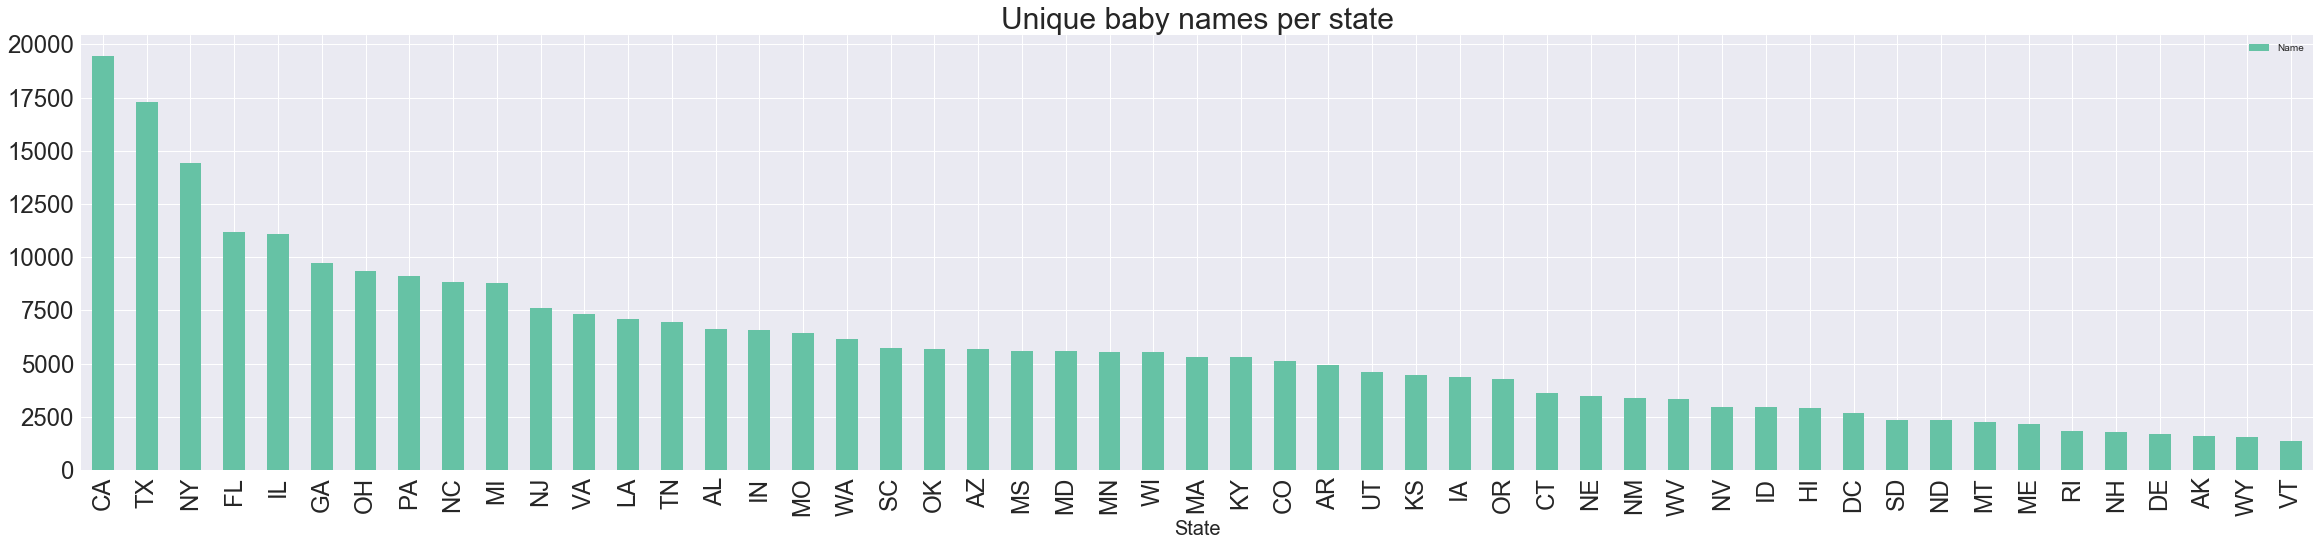

In [16]:
ax = State_names.plot(kind='bar',figsize=(40, 8), legend=True, fontsize=24)
ax.set_xlabel("State", fontsize=20)
ax.set_title('Unique baby names per state', fontsize=30)

plt.show()

![Racial diversity Across United States](https://www.homesnacks.net/graphs/national/most-diverse-states-in-america-for-2019.png)


   I was also curious if people were naming their names more liberally such as same names are used for both girl and boy babies. I wrote the Unisex function to find number of names that were used in a unisex fashion, and sampled the time with 5 year periods. 

In [17]:
def Unisex(arg_df,arg_year):
    "Find the unisex names for a given year: df, year -> df"
    
    #Extract the Sex column values into separate columns for Male and Female
    df=pd.get_dummies(arg_df, prefix=['Sex'], columns=['Sex'])
    
    #Select the year
    df=df[df['Year']==arg_year].reset_index(drop=True)
    
    #Create columns for percent %Female and %Male 
    df=df.iloc[:,[2,4,5]]
    dd=pd.DataFrame(df.groupby(['Name']).sum())
    
        
    dd['Mixed']=dd['Sex_M']*dd['Sex_F']

    return dd[dd['Mixed']>0].shape[0]

In [18]:
unisexnames=[]
for i in range(1910,2010,5):
    unisexnames.append(Unisex(Names,i))

Text(0.5, 1.0, 'Names used for both Males and Females')

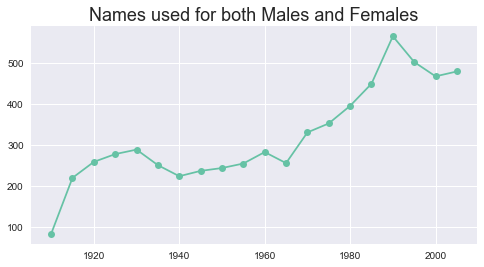

In [19]:
plt.figure(figsize=(8,4))
plt.plot(range(1910,2010,5), unisexnames,'-o')  
plt.title('Names used for both Males and Females',fontsize=18)

This plot indicates that is overall increasing trend where names are becoming more unisex. 